In [47]:
!pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0,ResNet50, VGG16, InceptionV3
from tf_explain.core.grad_cam import GradCAM

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import random
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
df= pd.read_csv("/kaggle/input/nike-adidas-shoes-for-image-classification-dataset/labelnames.csv")
df.head()

,Name,Label
0,aadidas_ (10),Adidas
1,aadidas_ (11),Adidas
2,aadidas_ (12),Adidas
3,aadidas_ (13),Adidas
4,aadidas_ (14),Adidas


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    576 non-null    object
 1   Label   576 non-null    object
dtypes: object(2)
memory usage: 9.1+ KB


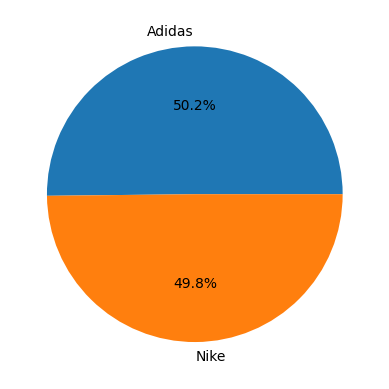

In [7]:
plt.pie(df['Label'].value_counts(), labels = df['Label'].unique(), autopct='%1.1f%%')
plt.show()

In [8]:
image_size = 224
batch_size = 32

In [9]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             zoom_range=0.2,
                             fill_mode='nearest')

test_datagen= ImageDataGenerator(rescale = 1/255.)
train_images = datagen.flow_from_directory("/kaggle/input/nike-adidas-shoes-for-image-classification-dataset/train",
                                           target_size=(image_size, image_size),
                                           subset="training",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle = True)

val_images = datagen.flow_from_directory("/kaggle/input/nike-adidas-shoes-for-image-classification-dataset/validation",
                                         target_size=(image_size, image_size),
                                         batch_size=batch_size,
                                         class_mode='categorical',
                                         shuffle = True)

test_images = test_datagen.flow_from_directory("/kaggle/input/nike-adidas-shoes-for-image-classification-dataset/test",
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 460 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


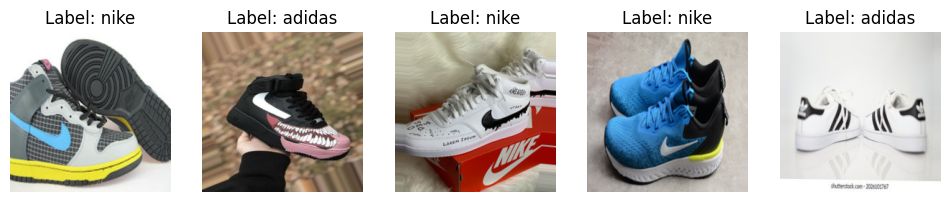

In [50]:
images, labels = next(train_images)
class_names = list(train_images.class_indices.keys())

plt.figure(figsize=(12, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    label_index = np.argmax(labels[i])
    plt.title(f"Label: {class_names[label_index]}")
plt.show()

In [84]:
true_labels = test_images.labels
print(true_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [85]:
class_names = list(test_images.class_indices.keys())
print(class_names)

['adidas', 'nike']


# Work with pretrained models

In [10]:
def create_model(base_model):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def plot_training_history(history):
    fig, axs= plt.subplots(1, 2, figsize=(12, 6))
    sns.lineplot(history.history['accuracy'], ax= axs[0], label='accuracy', marker="o")
    sns.lineplot(history.history['val_accuracy'],ax= axs[0], label='val_accuracy', marker="o")

    sns.lineplot(history.history['loss'], ax= axs[1], label='loss', marker="o")
    sns.lineplot(history.history['val_loss'], ax= axs[1], label='val_loss', marker="o")
    
    for ax in axs:
        ax.set_xticks(range(len(history.history['accuracy'])))
        ax.set_xticklabels(range(1, len(history.history['accuracy']) + 1))
        ax.set_xlabel('Epochs')
        ax.legend()
        ax.grid()
    plt.show()

## EfficientNet

In [12]:
EfficientNet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
EfficientNet_base_model.trainable = False
EfficientNet_model = create_model(EfficientNet_base_model)

monitor1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history1 = EfficientNet_model.fit(train_images, validation_data = val_images, epochs = 100, callbacks =[monitor1])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4976 - loss: 0.7386 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4803 - loss: 0.7252 - val_accuracy: 0.5091 - val_loss: 0.6931
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5330 - loss: 0.6999 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5174 - loss: 0.7060 - val_accuracy: 0.5091 - val_loss: 0.6934
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4833 - loss: 0.7027 - val_accuracy: 0.5091 - val_loss: 0.6940
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4654 - loss: 0.7085 - val_accuracy: 0.5091 - val_loss: 0.6934
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5196 - loss: 0.7066 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accurac

In [13]:
EfficientNet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,567,659 (17.42 MB)

 Trainable params: 172,610 (674.26 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

 Optimizer params: 345,222 (1.32 MB)

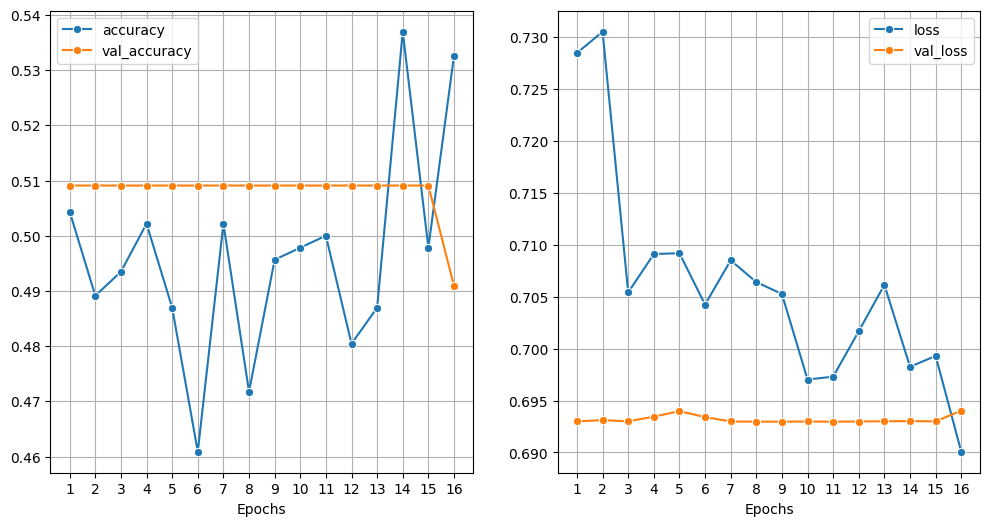

In [14]:
plot_training_history(history1)

In [135]:
loss, acc = EfficientNet_model.evaluate(test_images)
print(f'Test accuracy: {acc}')
print(f'Test loss: {loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 992ms/step - accuracy: 0.3542 - loss: 0.6976
Test accuracy: 0.5
Test loss: 0.6934028267860413


In [66]:
pred_probs_EfficientNet = EfficientNet_model.predict(test_images)
pred_labels_EfficientNet = np.argmax(pred_probs_EfficientNet, axis=1)
pred_probabilities_EfficientNet = np.max(pred_probs_EfficientNet, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


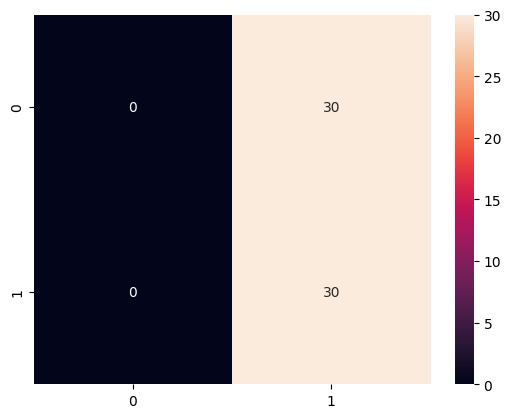

In [67]:
sns.heatmap(confusion_matrix(true_labels, pred_labels_EfficientNet), annot =True)
plt.show()

In [68]:
print(classification_report(true_labels, pred_labels_EfficientNet, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.00      0.00      0.00        30
        nike       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



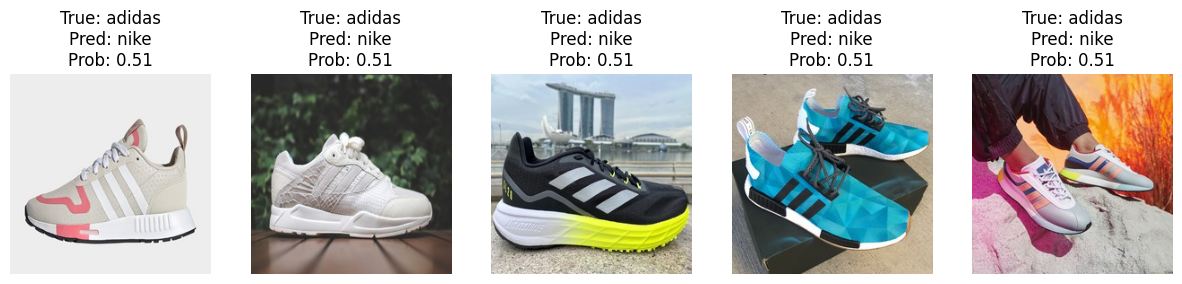

In [87]:
images, _ = next(test_images)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    pred_class = class_names[pred_labels_EfficientNet[i]]
    true_class = class_names[true_labels[i]]
    prob = pred_probabilities_EfficientNet[i]
    plt.title(f"True: {true_class}\nPred: {pred_class}\nProb: {prob:.2f}")
plt.show()

## ResNet

In [16]:
ResNet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
ResNet_base_model.trainable = False
ResNet_model = create_model(ResNet_base_model)

monitor2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history2 = ResNet_model.fit(train_images, validation_data = val_images, epochs = 100, callbacks =[monitor2])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5467 - loss: 0.7538 - val_accuracy: 0.5091 - val_loss: 0.7471
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.6544 - loss: 0.5848 - val_accuracy: 0.5273 - val_loss: 0.7013
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.6936 - loss: 0.5459 - val_accuracy: 0.5091 - val_loss: 0.7100
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7257 - loss: 0.5505 - val_accuracy: 0.5091 - val_loss: 0.7391
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7903 - loss: 0.4588 - val_accuracy: 0.5091 - val_loss: 0.7158


In [17]:
ResNet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,400,712 (93.08 MB)

 Trainable params: 270,914 (1.03 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

 Optimizer params: 541,830 (2.07 MB)

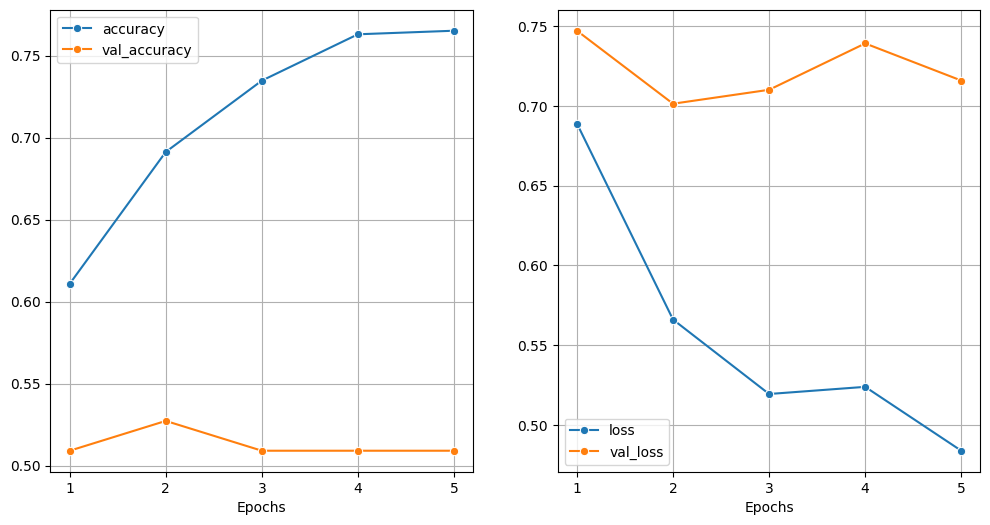

In [18]:
plot_training_history(history2)

In [19]:
loss2, acc2 = ResNet_model.evaluate(test_images)
print(f'Test accuracy: {acc2}')
print(f'Test loss: {loss2}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3757 - loss: 0.7824
Test accuracy: 0.5166666507720947
Test loss: 0.6933825016021729


In [63]:
pred_probs_ResNet = ResNet_model.predict(test_images)
pred_labels_ResNet = np.argmax(pred_probs_ResNet, axis=1)
pred_probabilities_ResNet = np.max(pred_probs_ResNet, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


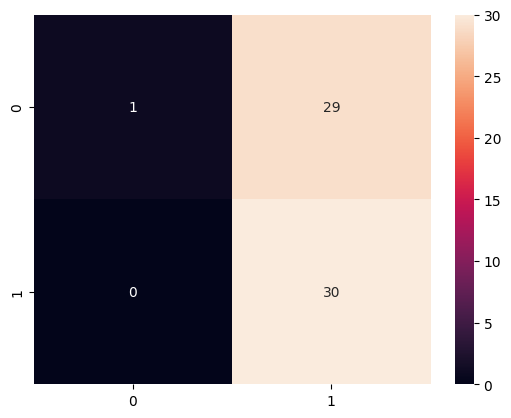

In [64]:
sns.heatmap(confusion_matrix(true_labels, pred_labels_ResNet), annot =True)
plt.show()

In [65]:
print(classification_report(true_labels, pred_labels_ResNet, target_names=class_names))

              precision    recall  f1-score   support

      adidas       1.00      0.03      0.06        30
        nike       0.51      1.00      0.67        30

    accuracy                           0.52        60
   macro avg       0.75      0.52      0.37        60
weighted avg       0.75      0.52      0.37        60



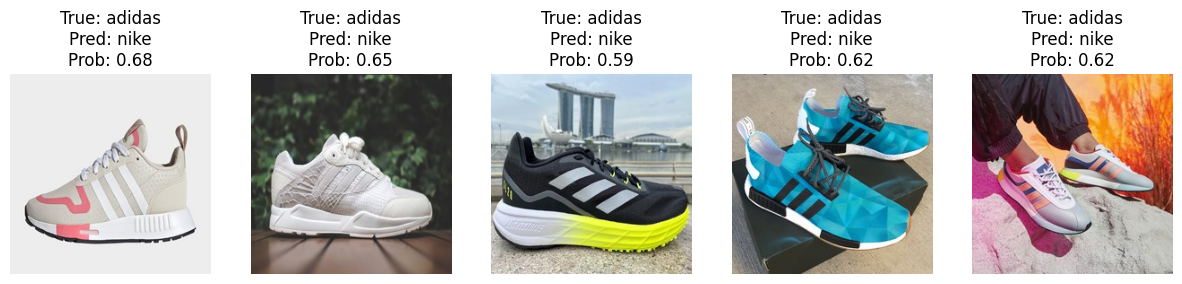

In [89]:
images, _ = next(test_images)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    pred_class = class_names[pred_labels_ResNet[i]]
    true_class = class_names[true_labels[i]]
    prob = pred_probabilities_ResNet[i]
    plt.title(f"True: {true_class}\nPred: {pred_class}\nProb: {prob:.2f}")
plt.show()

## Inception

In [20]:
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
InceptionV3_base_model.trainable = False
InceptionV3_model = create_model(InceptionV3_base_model)

monitor3 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history3 = InceptionV3_model.fit(train_images, validation_data = val_images, epochs = 100, callbacks =[monitor3])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6796 - loss: 0.5871 - val_accuracy: 0.6909 - val_loss: 0.5410
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8190 - loss: 0.3658 - val_accuracy: 0.6545 - val_loss: 0.7462
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8540 - loss: 0.3179 - val_accuracy: 0.6909 - val_loss: 0.6260
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9298 - loss: 0.2179 - val_accuracy: 0.7818 - val_loss: 0.5331
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9237 - loss: 0.1992 - val_accuracy: 0.7273 - val_loss: 0.6845
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9283 - loss: 0.1775 - val_accuracy: 0.8364 - val_loss: 0.5369
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9404 - loss: 0.1642 - val_accuracy: 0.8364 - val_loss: 0.5344


In [21]:
InceptionV3_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,615,784 (86.27 MB)

 Trainable params: 270,914 (1.03 MB)

 Non-trainable params: 21,803,040 (83.17 MB)

 Optimizer params: 541,830 (2.07 MB)

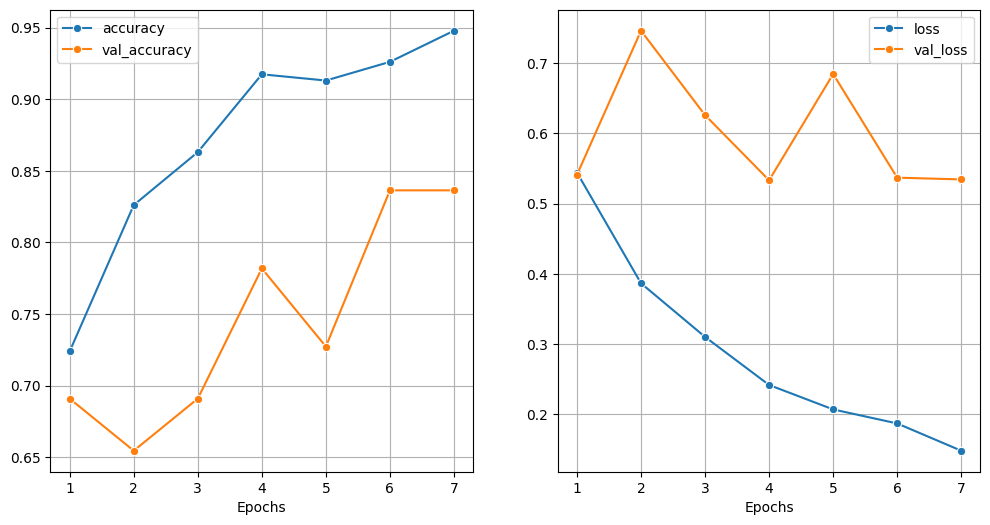

In [22]:
plot_training_history(history3)

In [23]:
loss3, acc3 = InceptionV3_model.evaluate(test_images)
print(f'Test accuracy: {acc3}')
print(f'Test loss: {loss3}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5146 - loss: 1.0301
Test accuracy: 0.6000000238418579
Test loss: 0.84711754322052


In [61]:
pred_probs_InceptionV3 = InceptionV3_model.predict(test_images)
pred_labels_InceptionV3 = np.argmax(pred_probs_InceptionV3, axis=1)
pred_probabilities_InceptionV3 = np.max(pred_probs_InceptionV3, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


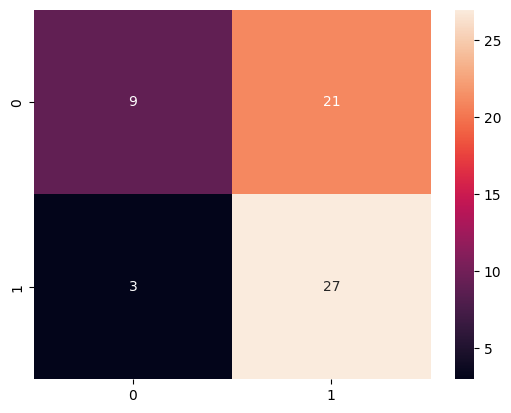

In [62]:
sns.heatmap(confusion_matrix(true_labels, pred_labels_InceptionV3), annot =True)
plt.show()

In [39]:
print(classification_report(true_labels, pred_labels_InceptionV3, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.75      0.30      0.43        30
        nike       0.56      0.90      0.69        30

    accuracy                           0.60        60
   macro avg       0.66      0.60      0.56        60
weighted avg       0.66      0.60      0.56        60



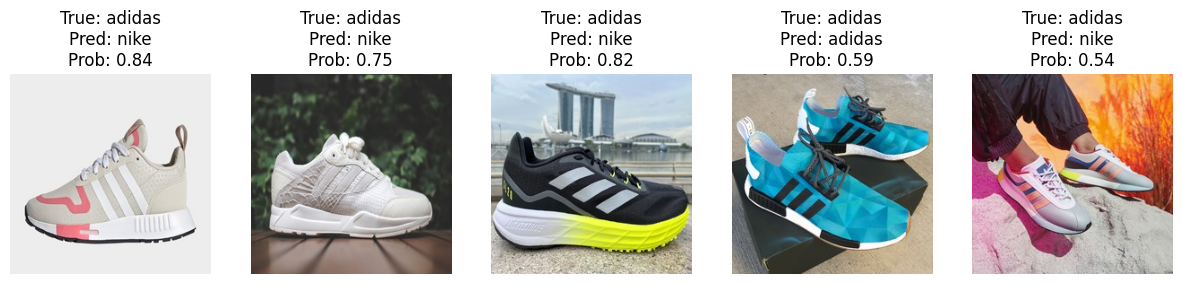

In [91]:
images, _ = next(test_images)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    pred_class = class_names[pred_labels_InceptionV3[i]]
    true_class = class_names[true_labels[i]]
    prob = pred_probabilities_InceptionV3[i]
    plt.title(f"True: {true_class}\nPred: {pred_class}\nProb: {prob:.2f}")
plt.show()

## VGG16

In [97]:
VGG16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
VGG16_base_model.trainable = False
VGG16_model = create_model(VGG16_base_model)

monitor4 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history4 = VGG16_model.fit(train_images, validation_data = val_images, epochs = 100, callbacks =[monitor4])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.6312 - loss: 0.6375 - val_accuracy: 0.5818 - val_loss: 0.6768
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.7885 - loss: 0.4267 - val_accuracy: 0.6000 - val_loss: 0.6650
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.8489 - loss: 0.3142 - val_accuracy: 0.6364 - val_loss: 0.6545
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 134s 9s/step - accuracy: 0.8384 - loss: 0.3382 - val_accuracy: 0.5636 - val_loss: 0.6473
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 133s 9s/step - accuracy: 0.9092 - loss: 0.2839 - val_accuracy: 0.6182 - val_loss: 0.6283
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.9178 - loss: 0.2353 - val_accuracy: 0.6545 - val_loss: 0.6168
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 133s 9s/step - accuracy: 0.9135 - loss: 0.2057 - val_accuracy: 0.6182 - val_loss: 0.6345
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 133s 9s/step -

In [98]:
VGG16_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,937,864 (56.98 MB)

 Trainable params: 74,306 (290.26 KB)

 Non-trainable params: 14,714,944 (56.13 MB)

 Optimizer params: 148,614 (580.53 KB)

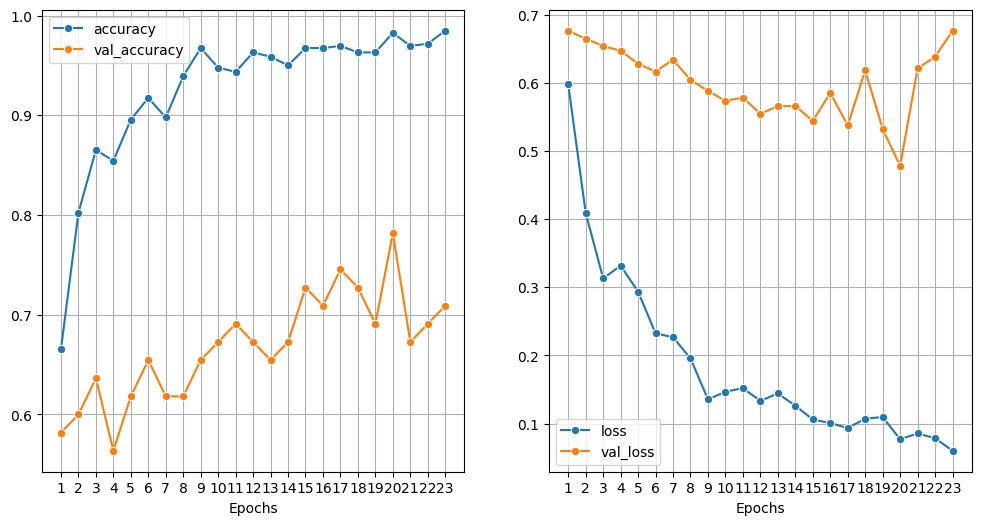

In [99]:
plot_training_history(history4)

In [100]:
loss4, acc4 = VGG16_model.evaluate(test_images)
print(f'Test accuracy: {acc4}')
print(f'Test loss: {loss4}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.8479 - loss: 0.3786
Test accuracy: 0.8500000238418579
Test loss: 0.39832088351249695


In [102]:
pred_probs_VGG16 = VGG16_model.predict(test_images)
pred_labels_VGG16 = np.argmax(pred_probs_VGG16, axis=1)
pred_probabilities_VGG16 = np.max(pred_probs_VGG16, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step


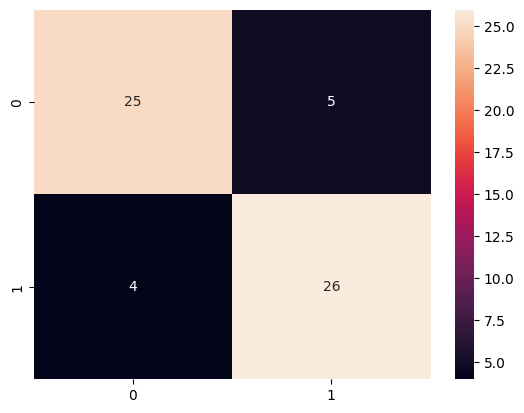

In [103]:
sns.heatmap(confusion_matrix(true_labels, pred_labels_VGG16), annot =True)
plt.show()

In [104]:
print(classification_report(true_labels, pred_labels_VGG16, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.86      0.83      0.85        30
        nike       0.84      0.87      0.85        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



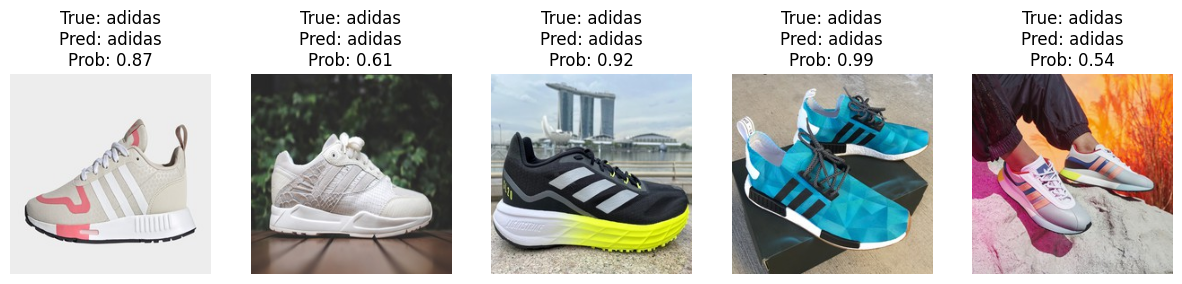

In [108]:
images, _ = next(test_images)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    pred_class = class_names[pred_labels_VGG16[i]]
    true_class = class_names[true_labels[i]]
    prob = pred_probabilities_VGG16[i]
    plt.title(f"True: {true_class}\nPred: {pred_class}\nProb: {prob:.2f}")
plt.show()

# Models comparison

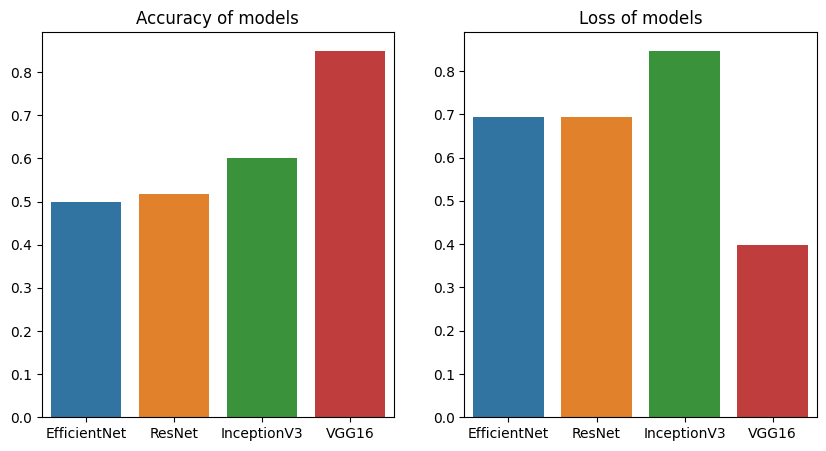

In [144]:
models = ["EfficientNet", "ResNet", "InceptionV3", "VGG16"]
accuracy = [acc, acc2, acc3, acc4]
models_loss= [loss, loss2, loss3, loss4 ]

fig, axes =plt.subplots(1, 2, figsize =(10, 5))
sns.barplot(x = models, y = accuracy, ax = axes[0])
axes[0].set_title("Accuracy of models")
sns.barplot(x = models, y = models_loss, ax = axes[1])
axes[1].set_title("Loss of models")
plt.show()

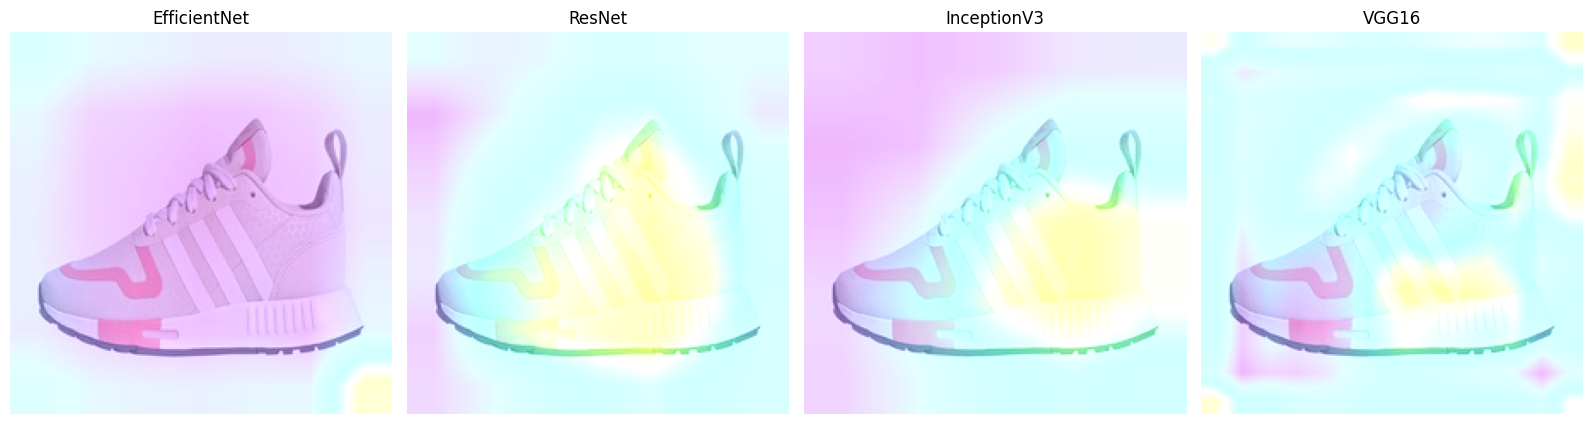

In [116]:
def get_gradcam_explanation(model, image, layer_name="mixed10", class_index=0):
    explainer = GradCAM()
    explanations = explainer.explain(
        validation_data=(image, _),
        model=model,
        layer_name=layer_name,
        class_index=class_index
    )
    return explanations

test_image, test_label = next(test_images)
test_image = test_image[:1]
true_labels = test_label[:1]

models = {
    "EfficientNet": {"model": EfficientNet_base_model, "layer": "top_conv"},
    "ResNet": {"model": ResNet_base_model, "layer": "conv5_block3_out"},
    "InceptionV3": {"model": InceptionV3_base_model, "layer": "mixed10"},
    "VGG16":{"model": VGG16_base_model, "layer": "block5_conv3"}
}

plt.figure(figsize=(20, 10))

for j, (model_name, model_info) in enumerate(models.items()):
    model = model_info["model"]
    layer_name = model_info["layer"]
    
    explanation = get_gradcam_explanation(model, test_image, layer_name=layer_name)
    plt.subplot(1, 5, j + 2)
    plt.imshow(explanation, cmap='jet', alpha=0.8) 
    plt.axis('off')
    plt.title(f"{model_name}")

plt.tight_layout()
plt.show()